### Notebook to genereate plots of binned variables based on 2D index array.

James Ruppert  
jruppert@ou.edu  
1/9/25

In [54]:
import numpy as np
from write_binned_functions import *
import pickle
from read_wrf_piccolo import *
from matplotlib import rc, colors, ticker
import matplotlib.pyplot as plt
import seaborn as sns

### Main settings

In [55]:
binvar_tag = 'sf' # saturation fraction

# Scratch
# datdir = "/glade/derecho/scratch/ruppert/piccolo/"
# Campaign storage
datdir = "/glade/campaign/univ/uokl0053/"
# OSCER
# datdir = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/piccolo/"

case = "sept1-4"

test = 'ctl'
test_str = 'CTL'

wrf_dom = "wrf_fine"
nmem = 5 # number of ensemble members

# Get list of variable names and pclasses
var_list, pclass_names = get_variable_list()
pclass_title = ["Non-cloud", "Deep", "Cong", "Shallow", "Strat", "Anvil"]
npclass = len(pclass_title)
ipclass_plot  = [0,1,2,3,4,5]
# ipclass_plot  = [1,2,3,4,5,6]
npclass = len(ipclass_plot)

# Time bounds of processed 3D variables
t0_3d = np.datetime64('2024-09-02T00:00:00')
t1_3d = np.datetime64('2024-09-03T00:00:00')

# Get date tag for post_proc output files
def get_datetag(datetime):
    string = np.datetime_as_string(datetime, unit='m').replace("-","").replace(" ","").replace(":","")
    return string
t0_str = get_datetag(t0_3d)
t1_str = get_datetag(t1_3d)
tag_postproc = '_'+t0_str+'-'+t1_str

# Ens-member string tags (e.g., memb_01, memb_02, etc.)
memb0=1 # Starting member to read
memb_nums_str=np.arange(memb0,nmem+memb0,1).astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

### Read functions

In [56]:
def read_binned_vars(test_string):
    var_list, pclass_names = get_variable_list()
    allvars = {}
    for var_tag in var_list:
        freq_binned = []
        rain_binned = []
        lwacre_binned = []
        pclass_freq = []
        invar_binned = []
        for memb_dir in memb_all:
            outdir, postproc_files, nt, nx, ny = get_postproc_dims(datdir, case, test_string, wrf_dom, memb_dir)
            # Read from pickle files
            pickle_file = outdir+'binned_'+binvar_tag+'/'+var_tag+tag_postproc+'.pkl'
            with open(pickle_file, 'rb') as file:
                main_dict = pickle.load(file)
            freq_binned.append(main_dict['freq_binned'])
            rain_binned.append(main_dict['rain_binned'])
            pclass_freq.append(main_dict['pclass_freq'])
            lwacre_binned.append(main_dict['lwacre_binned'])
            invar_binned.append(main_dict['invar_binned'])
        allvars['freq'] = np.array(freq_binned)
        allvars['rain'] = np.array(rain_binned)
        allvars['lwacre'] = np.array(lwacre_binned)
        allvars['pclass_freq'] = np.array(pclass_freq)
        allvars[var_tag] = np.array(invar_binned)
    bins = main_dict['bins']
    pres = main_dict['pres']
    return bins, pres, allvars

bins, pres, allvars = read_binned_vars('ctl')

### Plot functions

In [57]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

In [58]:
# Variable settings
# PW
ivar_select = binvar_tag
if ivar_select == 'pw':
    # fmin=35;fmax=80 # mm
    # step=1
    # bins=np.arange(fmin,fmax+step,step)
    xlabel='Column water vapor [mm]'
    log_x='linear'
# Column saturation fraction
elif ivar_select == 'sf':
    # fmin=30;fmax=100 # %
    fmin=.3;fmax=1 # %
    # step=0.01
    # bins=np.arange(fmin,fmax+step,step)
    # xlabel='Column saturation fraction [%]'
    xlabel='Column saturation fraction'
    log_x='linear'
# Rainfall rate
elif ivar_select == 'rain':
    # bins=10.**(np.arange(1,8,0.3)-4)
    # bins=10.**(np.arange(0,8,0.3)-4)
    xlabel='Rainfall rate [mm/hr]'
    log_x='log'
# LW-ACRE
elif ivar_select == 'lwacre':
    # fmin=-50; fmax=200 # W/m2
    # step=5
    # bins=np.arange(fmin,fmax+step,step)
    xlabel='LW-ACRE [W/m$^2$]'
    log_x='linear'
# Vertical mass flux
elif ivar_select == 'vmf':
    # bins=10.**(np.arange(1,8,0.3)-3)
    # bins=np.flip(-1.*bins)
    xlabel='Vertical mass flux [kg/m/s]'
    log_x='log'
# Theta-e (equivalent potential temperature)
elif ivar_select == 'th_e':
    # fmin=315; fmax=365 # K
    # step=1
    # bins=np.arange(fmin,fmax+step,step)
    xlabel=r'$\theta_e$ [K]'
    log_x='linear'

In [59]:
# Three-dimensional dependent variables ("var")
def get_fillvar_specs(fillvar_select):
    # Radar Reflectivity
    if fillvar_select == 'dbz':
        title = 'Ref'
        units_var1 = 'dBZ'
        cmin = -20; cmax=20
        cmap='RdBu_r'
    # Radiation
    elif fillvar_select == 'lwcrf':
        title = 'LW-CRF'
        cmap='RdBu_r'
        units_var1 = 'K/d'
        cmax=4; cmin=-1.*cmax
    # Horizontal temperature anomaly
    elif fillvar_select == 'tprm':
        title = r"$\theta_v'$"
        units_var1 = 'K'
        # cmax=1; cmin=-1.*cmax
        cmap='RdBu_r'
        cmax=2; cmin=-1.*cmax
        cmax_diff=.4; cmin_diff=-1.*cmax_diff
    # Relative humidity
    elif fillvar_select == 'rh':
        title = "RH"
        units_var1 = '%'
        # cmap='RdBu_r'
        cmap='BrBG'
        cmax=100; cmin=20
        cmax_diff=2; cmin_diff=-1*cmax_diff
    # Absolute vorticity
    elif fillvar_select == 'avor':
        title = "AVor"
        cmap='GnBu'
        units_var1 = '10$^{-6}$ /s'
        cmax=100; cmin=20
        cmax_diff=100; cmin_diff=-1*cmax_diff
    return title, units_var1, cmap, cmax, cmin#, cmax_diff, cmin_diff

def getrh(allvars):
    qv = allvars['qvapor']
    tmpk = allvars['tmpk']
    return calc_relh(qv, pres[np.newaxis,:,np.newaxis]*1e2, tmpk, ice=True)

#### Main plot code

In [70]:
def create_cross_section(allvars, fillvar_select, cvar_select, bins, pres, test_str):

    title, units_var1, cmap, cmax, cmin = get_fillvar_specs(fillvar_select)

    fig_title = title+' ('+test_str.upper()+')'

    # create figure
    sizex=11
    sizey=8.5
    fig, axs = plt.subplots(2, 1, figsize=(sizex,sizey), height_ratios=[.65,.35], layout='constrained',
                            squeeze=True)
    fig.suptitle(fig_title)

    ########################################

    # SET UP PLOTTING VARIABLES

    if fillvar_select == 'lwcrf':
        pltvar = allvars['rthratlw']*3600*24 # K/s --> K/day
        pltvar -= allvars['rthratlwc']*3600*24
    elif fillvar_select == 'rh':
        pltvar = getrh(allvars)

    if cvar_select == 'w':
        cpltvar = allvars['w']*1e2 # m/s --> cm/s
        cont_levs = [1,5,10,50,100,500,1000]
        cont_levs = np.concatenate((-1*np.flip(cont_levs),cont_levs))
    elif cvar_select == 'rh':
        cpltvar = getrh(allvars)
        cont_levs = np.arange(20,120,5)

    pltvar = np.nanmean(pltvar, axis=0)
    cpltvar = np.nanmean(cpltvar, axis=0)

    pclass_binned = np.nanmean(allvars['pclass_freq'], axis=0)
    rain_binned = np.nanmean(allvars['rain'], axis=0)
    lwacre_binned = np.nanmean(allvars['lwacre'], axis=0)

    # MAIN PANEL

    axs[0].set_ylabel('Pressure [hPa]')

    # fill contour
    nbins = bins.shape[0]
    nlevs=31
    inc=(cmax-cmin)/nlevs
    clevs = np.arange(cmin, cmax+inc, inc)
    if fillvar_select == 'lwcrf':
        norm = colors.TwoSlopeNorm(vmin=-7, vcenter=0, vmax=5)
    else:
        norm = colors.Normalize(vmin=cmin, vmax=cmax)
    im = axs[0].pcolormesh(bins[:-1], pres, pltvar, shading='nearest', cmap=cmap, alpha=0.8,
                        norm=norm,zorder=2)

    # plot colorbar
    fig.colorbar(im, ax=axs[0], shrink=0.75, ticks=ticker.AutoLocator(), label=units_var1,
                pad=-0.12)

    axs[0].set_ylim(100,np.max(pres))
    axs[0].invert_yaxis()
    axs[0].set_yscale('log')
    axs[0].set_xscale(log_x)
    axs[0].yaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[0].yaxis.set_minor_formatter(ticker.ScalarFormatter())

    # axs[0].set_xlabel(xlabel)
    if ivar_select == 'sf':
        xlim = (0.4, 0.95)
        xlim = (0.7, 0.95)
    else:
        xlim = (np.min(bins), np.max(bins))
    axs[0].set_xlim(xlim)

    # Line contour
    im = axs[0].contour(bins[0:nbins-1], pres, cpltvar, cont_levs, colors='black', zorder=2)
    axs[0].clabel(im, im.levels, inline=True, fontsize=13)

    ########################################

    # STRAT FRACTION PANEL
    subp_title = 'Cloud Classification'# ('+hr_tag+' h)'
    axs[1].set_xlabel(xlabel)
    axs[1].set_xscale(log_x)

    # As fraction of all-points-total
    axs[1].set_ylabel('Area fraction (*10$^3$)')

    linewidth=1.6

    total=np.nansum(pclass_binned)
    total*=1e-3
    axs[1].plot(bins[0:nbins-1], pclass_binned[...,1]/total \
    , "-r", label="Deep", linewidth=linewidth)
    axs[1].plot(bins[0:nbins-1], pclass_binned[...,4]/total \
    , "--r", label="Strat", linewidth=linewidth)
    axs[1].plot(bins[0:nbins-1], pclass_binned[...,5]/total \
    , ":r", label="Anvil", linewidth=linewidth)

    axs[1].set_xlim(xlim)

    # Dummy placeholders just to include in legend
    axs[1].plot(bins[0:nbins-1], rain_binned*np.nan, "-k", label="Rain rate", linewidth=linewidth)
    axs[1].plot(bins[0:nbins-1], rain_binned*np.nan, "--k", label="LW-ACRE", linewidth=linewidth)
    # axs[1].plot(bins[0:nbins-1], rain_binned[ktest,:]*np.nan, "--k", label="Percent.", linewidth=2)

    # Add rain rate
    twin1 = axs[1].twinx()
    twin1.plot(bins[0:nbins-1], rain_binned, "-k", label="Rain", linewidth=linewidth)
    twin1.set_ylabel('mm/hr')

    axs[1].legend(loc="upper left", prop={'size': 14})

    # Add LW-ACRE
    twin2 = axs[1].twinx()
    twin2.spines.right.set_position(("axes", 1.09))
    twin2.plot(bins[0:nbins-1], lwacre_binned, "--k", label="LW-ACRE", linewidth=linewidth)
    twin2.set_ylabel('W/m$^2$')

    # Set y-limits
    axs[1].set_ylim(0,5.5)
    twin1.set_ylim(0,23)
    twin2.set_ylim(0,135)

    plt.show()
    plt.close()
    return None

/glade/derecho/scratch/ruppert/tmp/ipykernel_33507/776081848.py:32: RuntimeWarning: Mean of empty slice
  pltvar = np.nanmean(pltvar, axis=0)
/glade/derecho/scratch/ruppert/tmp/ipykernel_33507/776081848.py:33: RuntimeWarning: Mean of empty slice
  cpltvar = np.nanmean(cpltvar, axis=0)
/glade/derecho/scratch/ruppert/tmp/ipykernel_33507/776081848.py:36: RuntimeWarning: Mean of empty slice
  rain_binned = np.nanmean(allvars['rain'], axis=0)
/glade/derecho/scratch/ruppert/tmp/ipykernel_33507/776081848.py:37: RuntimeWarning: Mean of empty slice
  lwacre_binned = np.nanmean(allvars['lwacre'], axis=0)


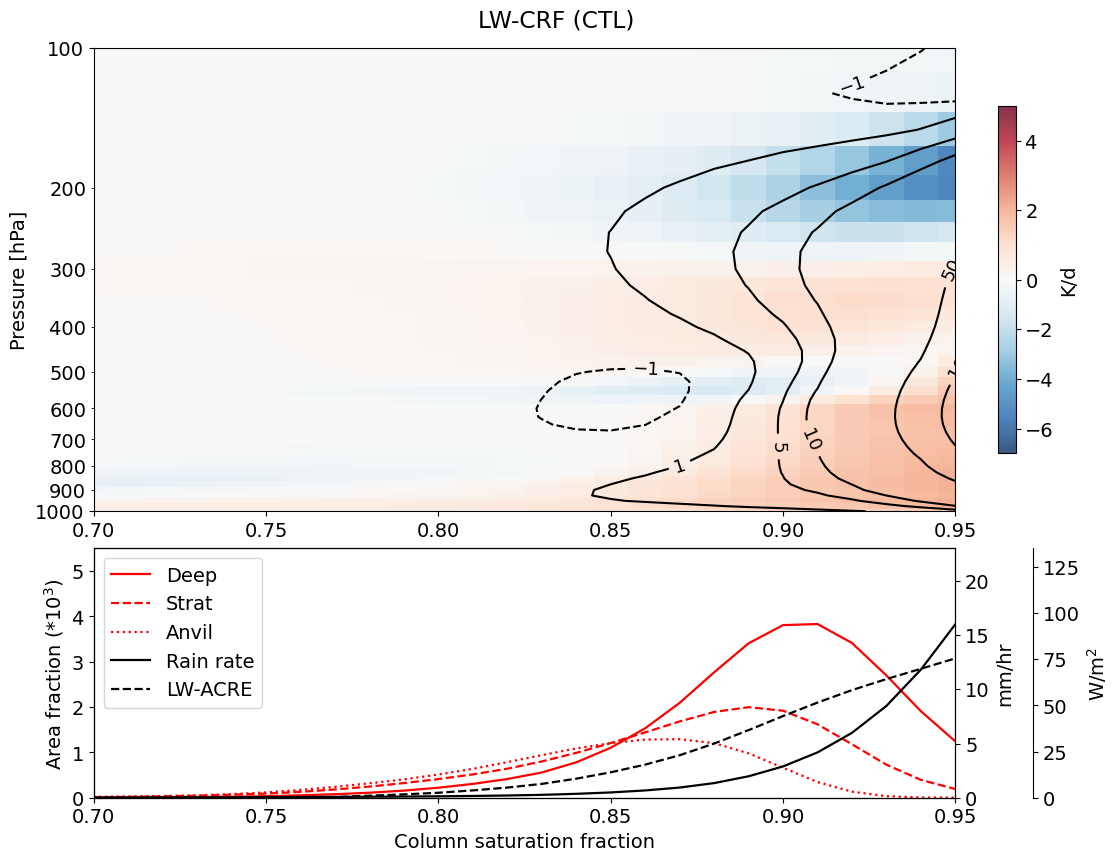

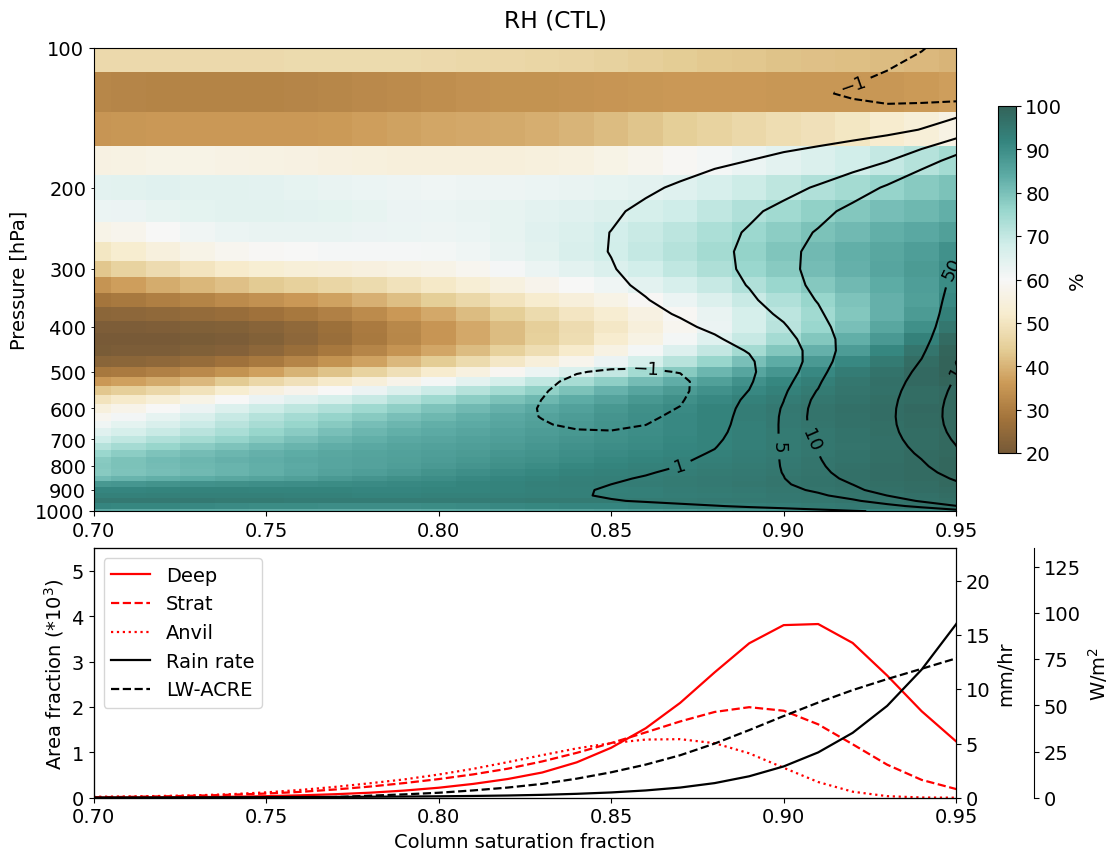

In [71]:
cvar_select = 'w'
# fillvar_select = 'rh'
for fillvar_select  in ['lwcrf','rh']:
    create_cross_section(allvars, fillvar_select, cvar_select, bins, pres, test_str)